In [1]:
import numpy as np
import xsim
import matplotlib.pyplot as plt
import matplotlib.patches as ptc

from atm.flight.operation import Operation
from atm.flight.flight import DUMMY_FLIGHT_RECAT
from atm.separation import recat

from atm.simulator.generator import RealTimeScenarioGenerator
from atm.simulator.stripe import Stripe


In [2]:
from IPython.display import clear_output
from time import sleep
from docplex.mp.model import Model
from typing import Tuple, Optional, Union
from atm.flight.flight import Flight
from atm.flight.scenario import Scenario
from atm.separation.base import Separation

from PIL import Image

In [3]:
parameter = dict(
    interval=180,
    window=dict(
        min=int(10*60),
        shift=int(3*60),
    ),
    mode="M",
    margin=dict(
        min=1500,
        shift=int(5*60)
    ),
)

MERGIN = 10
separation = recat.TBS

In [4]:
def fcfs_assign(stripes):
    last_vol = DUMMY_FLIGHT_RECAT
    last_time = last_vol.de
    for stripe in stripes:
        vol = stripe.vol
        sep = separation(last_vol, vol)
        time = np.max([last_time + sep + MERGIN, vol.ready])

        stripe.assign_time(time)
        stripe.assign_rwy("34L")

        last_vol = vol
        last_time = time

    return stripes


In [5]:
def ix(vol1: Flight, vol2: Optional[Flight] = None) -> Union[str, Tuple[str, str]]:
    if vol2 is None:
        return vol1.code

    return vol1.code, vol2.code

In [6]:
def build_model(vols: Scenario, sep: Separation) -> Tuple[Model, tuple, tuple]:
    M: int = 1000  # big-M

    m = Model("CADM")

    # define variables
    # assign time
    ts = {
        vol.code: m.integer_var(lb=vol.ready, ub=vol.due, name=f"T_{vol.code}")
        for vol in vols
    }
    # leader flag
    # y = 1 if vol1 leads vol2
    ys = {
        ix(vol1, vol2): m.binary_var(name=f"y_{vol1.code}_{vol2.code}")
        for vol1 in vols
        for vol2 in vols
        if not vol1 == vol2
    }

    # constrains
    [
        m.add_constraint(ts[ix(vol2)] >= ts[ix(vol1)] + sep(vol1, vol2) - M * (1 - ys[ix(vol1, vol2)]))
        for vol1 in vols
        for vol2 in vols
        if not vol1 == vol2
    ]

    [
        m.add_constraint(ys[ix(vol1, vol2)] + ys[ix(vol2, vol1)] == 1)
        for vol1 in vols
        for vol2 in vols
        if vol1 < vol2
    ]

    m.minimize(m.sum([
        ts[ix(vol)] - vol.ready
        for vol in vols
    ]))

    return m, ts, ys

In [58]:
def opt_assign(time, stripes):
    scenario = Scenario([
        vol.vol for vol in stripes # if vol.de >= time + 5 * 60
    ])
    m, ts, ys = build_model(scenario, separation)
    m.solve()

    for stripe, t in zip(stripes, ts.values()):
        stripe.assign_time(int(t.solution_value))
        stripe.assign_rwy("34L")

    return stripes


In [44]:
def draw(time, stripes):
    time_shift = time - 5 * 60
    num_vol = len(stripes)
    height = 1
    timespan = 60  # min
    timelimit = 10 # min

    if num_vol == 0:
        fig_height = 1
    else:
        fig_height = num_vol * 0.5 + 0.5
    fig, ax = plt.subplots(figsize=(20, fig_height))
    for i, vol in enumerate(stripes):
        i = num_vol - i - 1
        tde = vol.de
        tto = vol.to
        window_color = "r" if vol.ope == Operation.A else "b"
        window = ptc.Rectangle(
            (tde, height*(i+0.1)), tto - tde, height*0.8, color=window_color, alpha=0.2
        )
        window_border = ptc.Rectangle(
            (tde, height*(i+0.1)), tto - tde, height*0.8, color="k", alpha=1, fill=False, linewidth=2
        )
        tasign = vol.time
        ax.plot([tasign, tasign], [i*height, (i+1)*height], color=window_color, linewidth=3)
        ax.add_patch(window)
        ax.add_patch(window_border)

        code = vol.vol.code
        plt.text(tto+30, height*(i+0.3), code+"("+str(vol.cat)+")"+"|"+vol.rwy, fontsize=30)

    for i in range(num_vol - 1):
        vol1 = stripes[i].vol
        vol2 = stripes[i+1].vol
        tassign = stripes[i].time
        sep = separation(vol1, vol2)

        for k in range(num_vol):
            if i > k:
                continue
            k = num_vol - k - 1
            window_sep = ptc.Rectangle(
                (tassign, height*+k), sep, height, color="k", alpha=0.1
            )
            ax.add_patch(window_sep)

    timelimit = time + timelimit * 60
    min_height = height * (1 if num_vol == 0 else num_vol)
    ax.plot([time, time], [0, min_height], linewidth=3, linestyle="-", color="orange")
    ax.plot([timelimit, timelimit], [0, min_height], linewidth=3, linestyle="--", color="orange")
    ax.set_xlim(time_shift, time + timespan * 60)
    ax.set_ylim(0, min_height)
    xticks = np.arange((time + timespan * 60) // 300 + 1) * 300
    xticks = xticks[xticks >= time_shift]
    ax.set_xticks(xticks)
    ax.set_yticks([i*height for i in range(num_vol+1)])
    plt.grid()
    plt.show()

    return fig


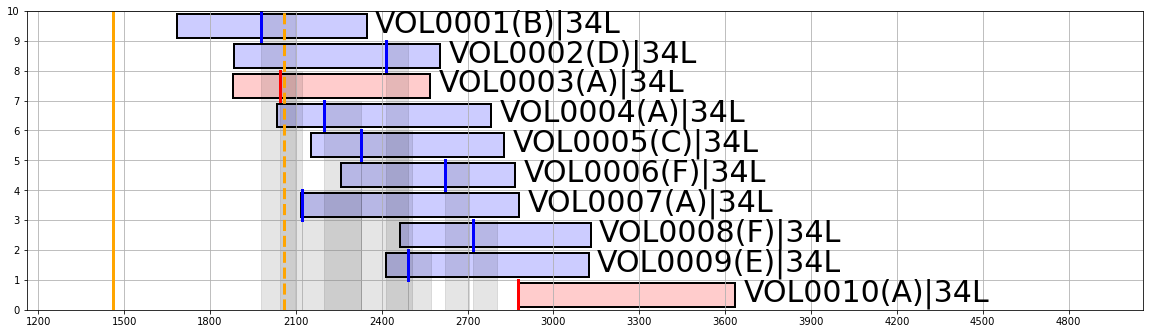

TypeError: '>=' not supported between instances of 'NoneType' and 'float'

In [48]:
dt = 1     # sec
due = 60   # min
queue = []
figs = []

rgen = RealTimeScenarioGenerator(parameter)
for time in xsim.generate_step_time(due * 60, dt):
    queue = [vol for vol in queue if vol.time >= time - 5 * 60]

    vol = rgen(dt=dt)
    if vol is not None:
        vol = Stripe(vol)
        queue.append(vol)
        # queue = fcfs_assign(queue)
        queue = opt_assign(time, queue)

    if (time % 10) == 0:
        clear_output()
        fig = draw(time, queue)
        figs.append(fig)

    sleep(1/200)



In [24]:
queue

In [25]:
scenario = Scenario([
    vol.vol for vol in queue if vol.de >= time + 5 * 60
])
m, ts, ys = build_model(scenario, separation)
m.solve()


docplex.mp.solution.SolveSolution(obj=0,values={T_VOL0001:1561})

In [31]:
ts[queue[0].vol.code].solution_value


1561.0

In [33]:
ys[queue[0].vol.code].solution_value

KeyError: 'VOL0001'

In [40]:
for key, val in ts.items():
    print(val.solution_value)


1561.0


In [60]:
parameter = dict(
  interval=120,
  window=300,
  category="recat",
  mode="mix",
)
from atm.flight.generator import ScenarioGenerator
sgen = ScenarioGenerator(parameter)

In [66]:
vols = sgen(5)
queue = [Stripe(vol) for vol in vols]
vols.to_dataframe()

,code,ready,due,category,operation
0,VOL0001,37,337,C,A
1,VOL0002,76,376,F,D
2,VOL0003,154,454,A,A
3,VOL0004,215,515,B,A
4,VOL0005,220,520,E,D


In [67]:
sol_fcfs = fcfs_assign(queue)
sol_times_fcfs = [s.time for s in sol_fcfs]
sol_times_fcfs


[37, 227, 319, 432, 588]

In [68]:
sol_opt = opt_assign(0, queue)
sol_times_opt = [s.time for s in sol_opt]
sol_times_opt


[158, 76, 297, 233, 451]

In [71]:
sol = vols.to_dataframe()
sol["fcfs"] = sol_times_fcfs
sol["opt"] = sol_times_opt
sol["dfcfs"] = sol["fcfs"] - sol["ready"]
sol["dopt"] = sol["opt"] - sol["ready"]
sol

,code,ready,due,category,operation,fcfs,opt,dfcfs,dopt
0,VOL0001,37,337,C,A,37,158,0,121
1,VOL0002,76,376,F,D,227,76,151,0
2,VOL0003,154,454,A,A,319,297,165,143
3,VOL0004,215,515,B,A,432,233,217,18
4,VOL0005,220,520,E,D,588,451,368,231


In [73]:
print("dfcfs:", sol.dfcfs.mean())
print("dopt:", sol.dopt.mean())


dfcfs: 180.2
dopt: 102.6
